# Abraham Maximiliano Ávalos Corrales
# David Omar Paredes Paredes

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random


In [2]:
def compare(fitness_a, fitness_b):
    # if a dominates b, return will be 1, -1 if the contrary
    # if there is no dominance, 0 will be returned
    if fitness_a[1] - fitness_b[1] == 0:
            if fitness_a[0] < fitness_b[0]:
                return 1
            return -1
    try:
        m = (fitness_a[0] - fitness_b[0]) / (fitness_a[1] - fitness_b[1])
    except ZeroDivisionError:
        return 0
    if m > 0:
        if fitness_a[0] < fitness_b[0]:
            return 1
        return -1
    return 0


In [3]:
def get_parent(parent_F):
    n = len(parent_F)  # Assuming n is the length of the parent_F list
    parent_candidates_idx = np.random.randint(0, n, 2)
    min_value = float('inf')
    min_index = None
    
    for idx in parent_candidates_idx:
        if parent_F[idx][2] < min_value:
            min_value = parent_F[idx][2]
            min_index = idx
    
    return min_index

In [4]:
def mix_parents(parent_a:list, parent_b:list, ratio:float = 0.5, get_indexes:bool=False):
	genotype_len = len(parent_a)

	a_idxs = set()
	acum = 0
	for i in range(genotype_len):
		acum += ratio
		if acum >= 1:
			acum -= 1
			a_idxs.add(i)
	b_idxs = {i for i in range(genotype_len)} - a_idxs

	a_idxs = list(a_idxs)
	b_idxs = list(b_idxs)
	child  = np.zeros((genotype_len), bool)

	child[a_idxs] = parent_a[a_idxs].copy()
	child[b_idxs] = parent_b[b_idxs].copy()
	if get_indexes:
		return child, (a_idxs, b_idxs)
	return child

In [5]:
def NSGA2(fitness):
    n = len(fitness)
    levels = np.zeros(n)
    dominates = [[] for _ in range(n)]
    #dd =  [[] for _ in range(n)]
    is_dominated_by = {}
    for i in range(n):
        is_dominated_by[i] = 0
    for idx_first_point, first_point in enumerate(fitness):
        for idx_second_point in range(idx_first_point+1, len(fitness)):
            second_point = fitness[idx_second_point]
            m = compare(first_point, second_point)
            if m == 1: #first_point dominates
                is_dominated_by[idx_second_point] +=1
                dominates[idx_first_point].append(idx_second_point)
                #dd[idx_second_point].append(idx_first_point)
            elif m == -1:
                is_dominated_by[idx_first_point] +=1
                dominates[idx_second_point].append(idx_first_point)
                #dd[idx_first_point].append(idx_second_point)
    
    #for bbb,pp in enumerate(dd):
     #   print(bbb,pp)

    
    curr_level = 0
    while len(is_dominated_by) > 0:
  
        non_dominated_indices = [idx for idx, dominance_count in is_dominated_by.items() if dominance_count == 0]

        for idx in non_dominated_indices:
            
            for dominated_idx in dominates[idx]:
                is_dominated_by[dominated_idx] -= 1
                
            levels[idx] = curr_level
            del is_dominated_by[idx]
        curr_level+=1
        
    return levels
    

In [6]:
def graphicate_points(points):
    # Set smaller figure size
    plt.figure(figsize=(8, 3))  # Adjust the width and height as needed

    # Plot the points
    for i, point in enumerate(points):
        plt.scatter(point[0], point[1], color='blue', s=50)  # Reduced marker size
        plt.text(point[0], point[1], str(i), fontsize=8, ha='center', va='bottom')

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Plot')

    # Set axis limits
    plt.xlim(0.40, 0.65)
    plt.ylim(0, 12)

    # Add grid
    plt.grid(True)

    plt.tight_layout()  # Ensure proper spacing

    plt.show()

In [7]:
def get_fitness(G, df, features_names, target_name):
    fitness = []
    for gi in G:
        selected_features = features_names[gi]

        # Prepare the data
        X = df[selected_features]
        y = df[target_name]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

        # Initialize and train the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        n_features_used = np.count_nonzero(gi)
        fitness.append([mae,n_features_used])
    
    levels = NSGA2(fitness)
    fitness_w_levels = [point + [lvl] for point, lvl in zip(fitness, levels)]
    
    #for fidx,fitn in enumerate(fitness_w_levels):
    #    print(fidx,": ",fitn)
    #print("levels:",levels)
    #graphicate_points(fitness)
    return fitness_w_levels


In [8]:
def mutate(gen):
    gen = gen.copy()
    rand = random.randint(0, len(gen) - 1)
    gen[rand] = not gen[rand]
    return gen

In [9]:
def get_elite(Fitness, G):
    elites_fitness = []
    elites_string = []
    for idx, fitn in enumerate(Fitness):
        if fitn[2]==0:
            elites_fitness.append(fitn.copy())
            elites_string.append(G[idx].copy())
    return elites_fitness, elites_string

In [10]:
def update_elite(E_fitness, E_newG_fitness, E_string, E_newG_string ):
    new_elite_fitness = []
    new_elite_string = []
    for idx,e in enumerate(E_fitness):
        new_elite_fitness.append(e.copy())
        new_elite_string.append(E_string[idx].copy())
    for idx,e in enumerate(E_newG_fitness):
        new_elite_fitness.append(e.copy())
        new_elite_string.append(E_newG_string[idx].copy())
    
    levels = NSGA2(new_elite_fitness)
    
    for idx, e in enumerate(new_elite_fitness):
        e[2] = levels[idx]
        
    return get_elite(new_elite_fitness, new_elite_string)

In [11]:
def get_features_names(E_string,features_names):
    features_by_each_elite = []
    for bool_list in E_string:
        features_by_each_elite.append([features_names[i] for i in range(len(bool_list)) if bool_list[i]])
    return features_by_each_elite

# Main

In [12]:
def solve(n, pCrossover, pMutation):
    #read csv
    filename = 'wine.csv'  
    df_wine = pd.read_csv(filename)
    num_features = df_wine.shape[1] -1
    
    #generate p0
    G = np.random.choice([False, True], size=(n, num_features))
    G[0] = np.full((1, num_features), True) # 1 with all features
    for row in G:
        if not np.any(row):
            row[np.random.randint(0, num_features)] = True
    features_names = df_wine.columns[:11]
    target_name = df_wine.columns[11]
    
    #get fitness
    F = get_fitness(G, df_wine, features_names, target_name)
    
    #Elite 
    E_fitness, E_string =  get_elite(F, G)
    graphicate_points(E_fitness)
    k = 0
    
    newG = np.empty(n, dtype=object)
    
    while k <= 20:
        k = k+1
        for i,curr_indiv in enumerate(G):

            if random.random() <= pCrossover:
                parent_idx1 = get_parent(F)
                parent_idx2 = get_parent(F)
                newG[i] = mix_parents(G[parent_idx1].copy(), G[parent_idx2].copy())
            else:
                newG[i] = G[i].copy()
            
            if random.random() <= pMutation:
                newG[i] = mutate(G[i])
        F_newG = get_fitness(newG, df_wine, features_names, target_name)
        E_newG_fitness, E_newG_string  = get_elite(F_newG, newG)
        E_fitness, E_string = update_elite(E_fitness, E_newG_fitness, E_string, E_newG_string )
        graphicate_points(E_fitness)
        
    feat_names = get_features_names(E_string,features_names)
    return feat_names, E_fitness

# Test functions

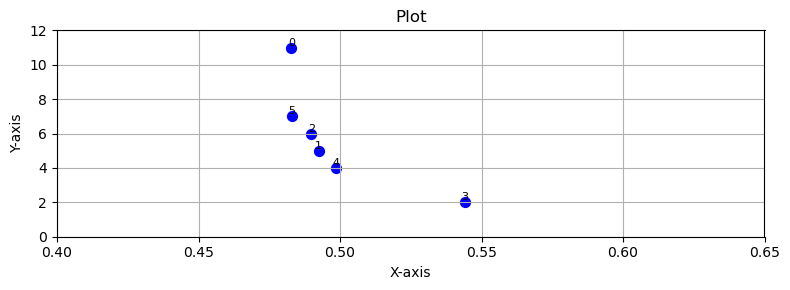

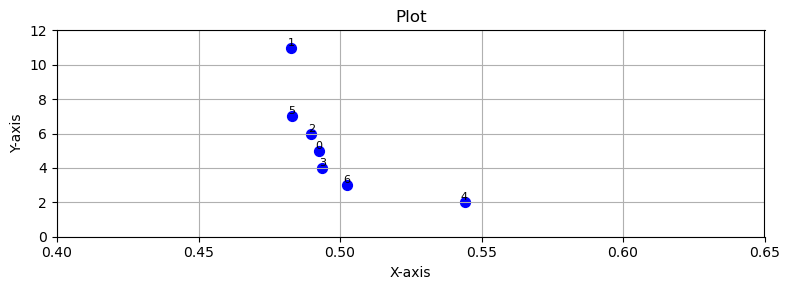

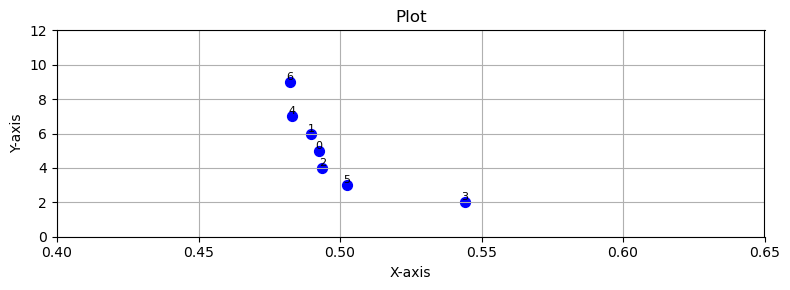

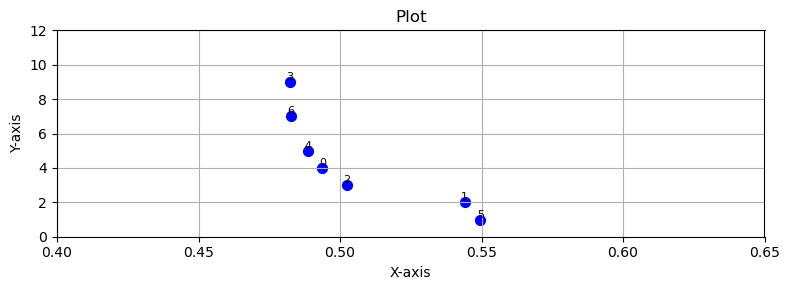

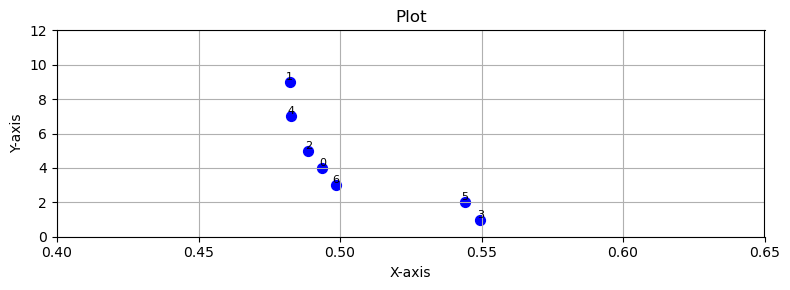

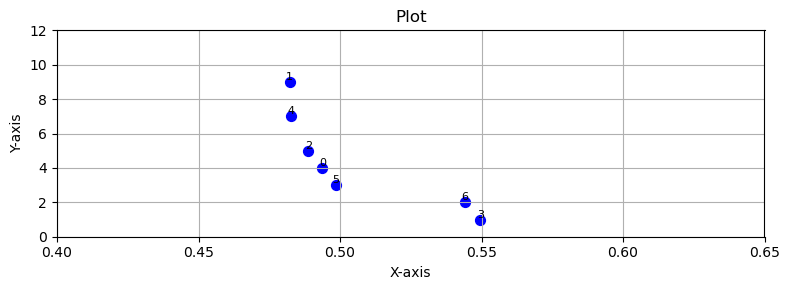

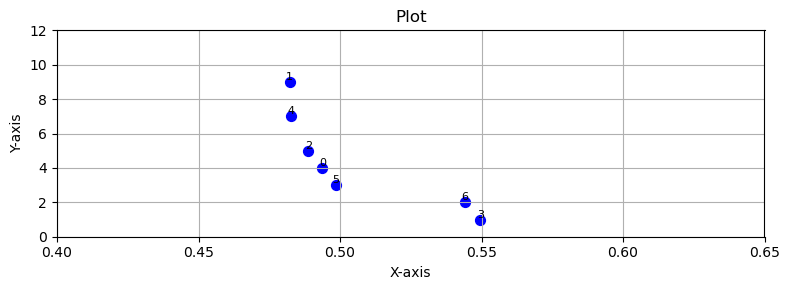

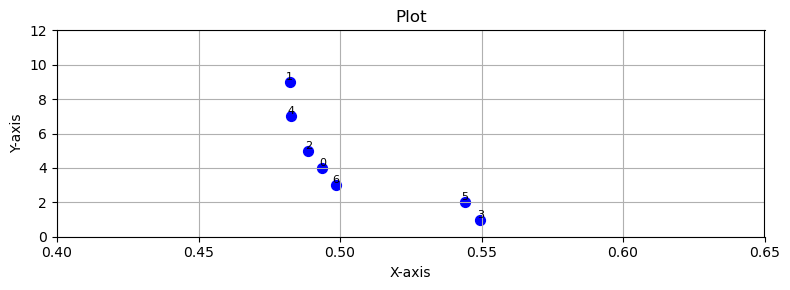

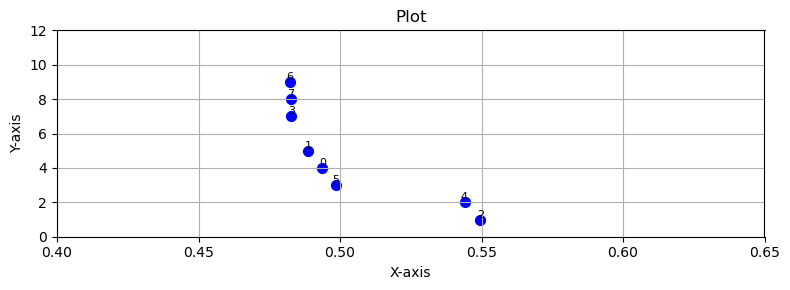

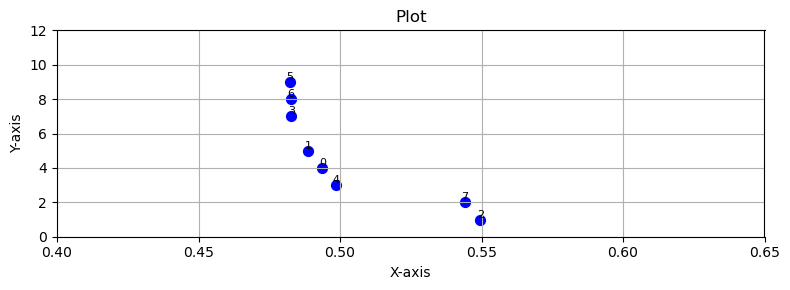

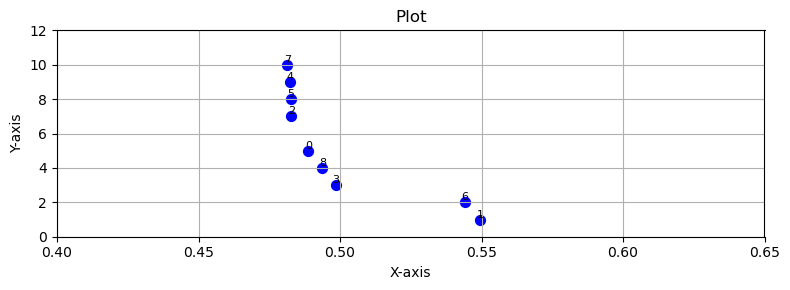

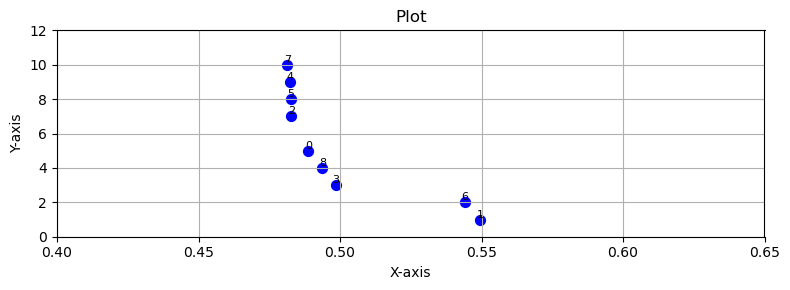

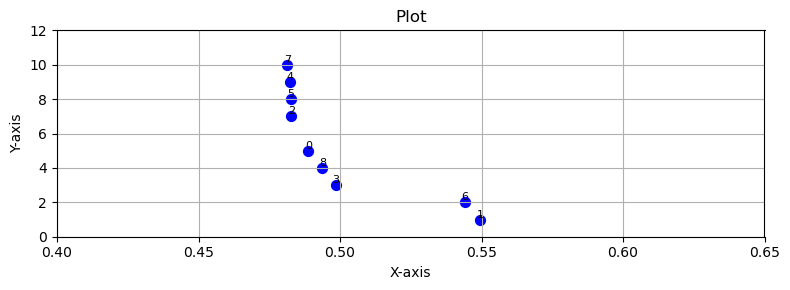

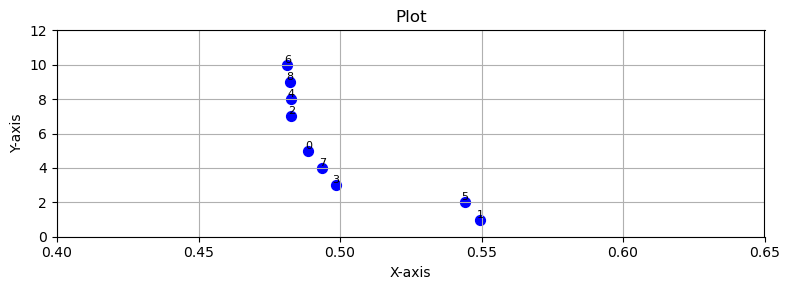

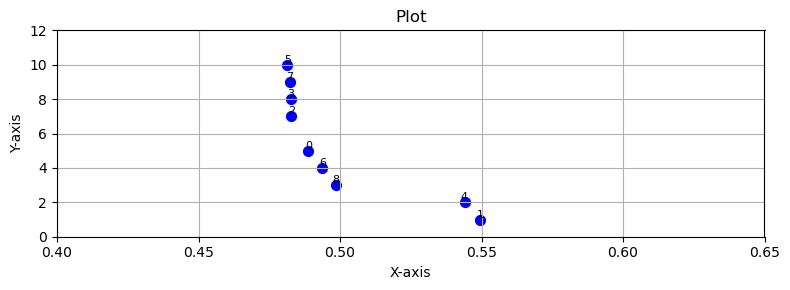

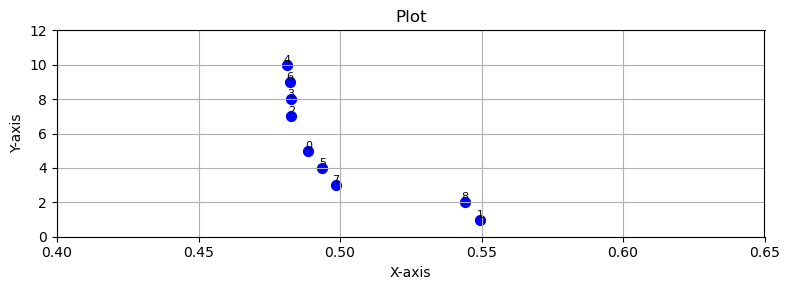

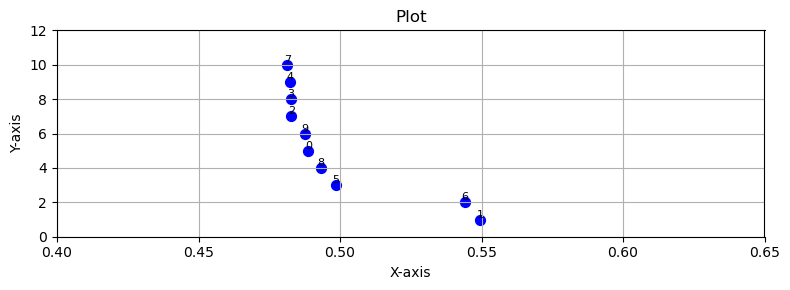

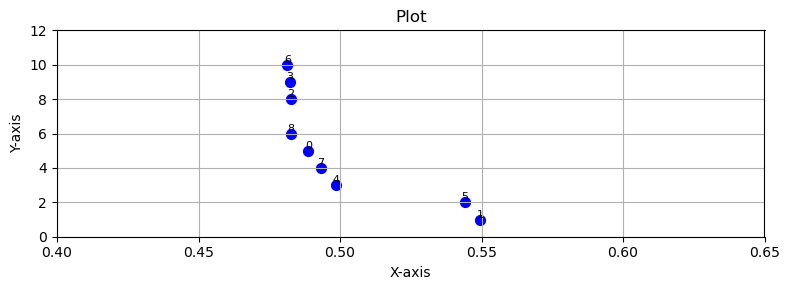

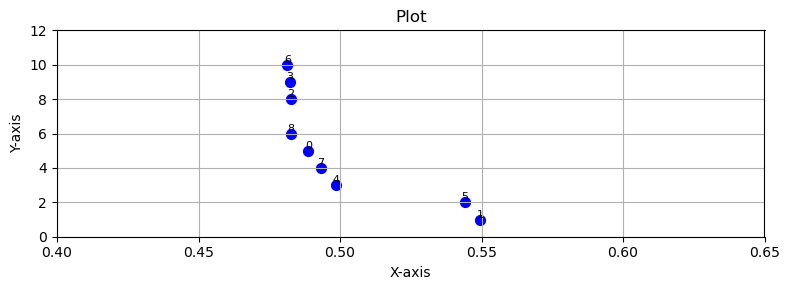

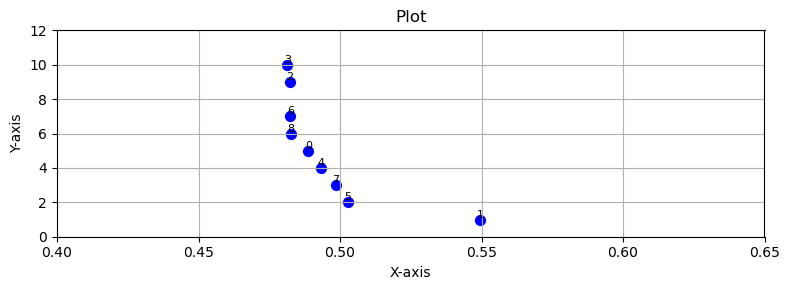

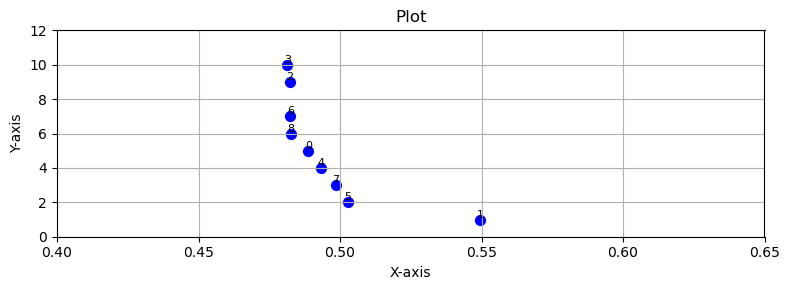

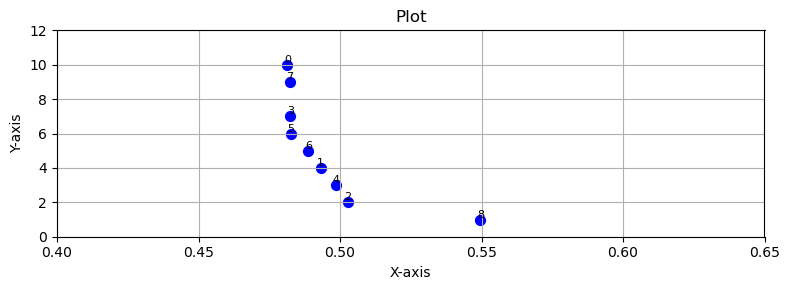

Elites: 
Elite:  0
MAE | Features used | Level:  [0.48141543493962097, 10, 0.0]
Features used:  ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'] 

Elite:  1
MAE | Features used | Level:  [0.4931322138306235, 4, 0.0]
Features used:  ['fixed acidity', 'volatile acidity', 'total sulfur dioxide', 'alcohol'] 

Elite:  2
MAE | Features used | Level:  [0.5027380124441805, 2, 0.0]
Features used:  ['volatile acidity', 'alcohol'] 

Elite:  3
MAE | Features used | Level:  [0.48248713992178777, 7, 0.0]
Features used:  ['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol'] 

Elite:  4
MAE | Features used | Level:  [0.4984527203696539, 3, 0.0]
Features used:  ['volatile acidity', 'total sulfur dioxide', 'alcohol'] 

Elite:  5
MAE | Features used | Level:  [0.48266815646429967, 6, 0.0]
Features used:  ['volatile acidity', 'chlorides', 'total sul

In [13]:
features, fitness = solve(60,0.5,0.5)
print("Elites: ")
for idx,f in enumerate(features):
    print("Elite: ", idx)
    print("MAE | Features used | Level: ",fitness[idx] )
    print("Features used: ", f,"\n")

In [14]:
def test_NSGA():
    fitn = [
        [1,2],
        [5,3],
        [6,5],
        [4,2],
        [2,4],
        [3.88,4.14],
        [3,3],
        [2,1]    
    ]

    levels = NSGA2(fitn)
    print(levels)